## Classification results

This notebook contains functions to measure the performance of a classifier applied over a set of annotations.

The output of the classification files is expected to be compatible with the output of the UKPLab models. Each line contains the token, the true label, and predicted label of one classification example, in that order, separated by tabs. The first row has the columns names. For example:

`word_n    I-Premise:2:Support    I-Premise:-1:Support`

Training results must be stored in tsv format with the following columns: epoch, modelName, dev_score, test_score, max_dev_score, max_test_score

In [25]:
%matplotlib inline
import numpy
import matplotlib.pyplot as plt
import pandas
import pickle
import os
import re
import seaborn as sns
from sklearn import metrics
sns.set_style('white')
sns.set_palette('colorblind')
sns.set_context("paper", font_scale=2)

In [86]:
CC_EXPERIMENTS_DIRS = [
    ## Exploration # No attention
#     '../../results/ukpnets/paragraph/18-11-14-14-49',
#     '../../results/ukpnets/paragraph/18-11-14-16-39',
#     '../../results/ukpnets/paragraph/18-11-14-18-15',
#     '../../results/ukpnets/paragraph/18-11-14-20-17',
#     '../../results/ukpnets/paragraph/18-11-14-22-02',
#     ## Exploration, word attention with sigmoid
#     '../../results/ukpnets/paragraph/18-11-14-22-22',
#     '../../results/ukpnets/paragraph/18-11-15-00-38',
#     '../../results/ukpnets/paragraph/18-11-15-02-17',
#     '../../results/ukpnets/paragraph/18-11-15-04-16',
#     '../../results/ukpnets/paragraph/18-11-15-06-01',
#     ## Exploration, word attention with None
#     '../../results/ukpnets/paragraph/18-11-15-09-54',
#     '../../results/ukpnets/paragraph/18-11-15-11-16',
#     '../../results/ukpnets/paragraph/18-11-15-13-21',
#     '../../results/ukpnets/paragraph/18-11-15-16-07',
#     '../../results/ukpnets/paragraph/18-11-15-17-58',
#     '../../results/ukpnets/paragraph/18-11-15-20-05',
#     '../../results/ukpnets/paragraph/18-11-15-21-15',
#     '../../results/ukpnets/paragraph/18-11-15-22-29',
#     '../../results/ukpnets/paragraph/18-11-16-00-25',
#     '../../results/ukpnets/paragraph/18-11-16-02-25',
#     '../../results/ukpnets/paragraph/18-11-16-03-52',
#     '../../results/ukpnets/paragraph/18-11-16-06-46',
    
    # '../../results/ukpnets/paragraph/18-11-15-10-16/',  # Time sigmoid not optimal
#     '../../results/ukpnets/paragraph/18-11-15-18-37/',  # Final time sigmoid
    
    # Exploration feature sigmoid
#     '../../results/ukpnets/paragraph/18-11-16-10-08',
#     '../../results/ukpnets/paragraph/18-11-16-14-01',
#     '../../results/ukpnets/paragraph/18-11-16-18-28',
#     '../../results/ukpnets/paragraph/18-11-16-22-24',
#     '../../results/ukpnets/paragraph/18-11-17-03-00',
    
    # Exploration feature tanh
#     '../../results/ukpnets/paragraph/18-11-17-06-54',
#     '../../results/ukpnets/paragraph/18-11-17-10-36',
#     '../../results/ukpnets/paragraph/18-11-17-13-57',
#     '../../results/ukpnets/paragraph/18-11-17-18-36',
#     '../../results/ukpnets/paragraph/18-11-17-22-40',
#     # Exploration feature none
#     '../../results/ukpnets/paragraph/18-11-18-02-37',
#     '../../results/ukpnets/paragraph/18-11-18-06-04',
#     '../../results/ukpnets/paragraph/18-11-18-09-54',
#     '../../results/ukpnets/paragraph/18-11-18-13-06',
#     '../../results/ukpnets/paragraph/18-11-18-16-32',
    
#     '../../results/ukpnets/paragraph/18-11-19-13-13',
#     '../../results/ukpnets/paragraph/18-11-19-14-12/',
    '../../results/ukpnets/claim-det-paragraph/18-11-19-17-43/',
    '../../results/ukpnets/claim-det-paragraph/18-11-19-18-37/',
]

## Classification Results - Dev and Test

In [87]:
def labels_single_file(filename):
    result = pandas.read_csv(filename, sep='\t')
    return result

In [88]:
def prediction_filenames(dirname):
    return [run_prediction for run_prediction in os.listdir(dirname)
            if os.path.isfile(os.path.join(dirname, run_prediction)) and 'predictions' in run_prediction]

In [89]:
def metrics_single_classifier(classifier_dirpath, dataset_name='ukp'):
    """Reads all partitions for a single classifier."""
    result = pandas.DataFrame(columns=[
        'Classifier', 'Partition', 'Dataset',
        'Accuracy', 'Precision', 'Recall', 'F1-Score'])
    for index, prediction_file in enumerate(prediction_filenames(classifier_dirpath)):
        predictions = labels_single_file(os.path.join(classifier_dirpath, prediction_file))
        accuracy = metrics.accuracy_score(predictions['True'], predictions.Predicted)
        precision, recall, f1, _ = metrics.precision_recall_fscore_support(
            predictions['True'], predictions.Predicted, average='weighted', warn_for=[])
        if 'partition' in prediction_file: 
            partition = re.search('.*partition(\d+).*', prediction_file).group(1)
        else:
            partition = 0
        dataset = re.search('.*{}_(\w+).conll'.format(dataset_name), prediction_file).group(1)
        classifier = os.path.basename(os.path.normpath(classifier_dirpath))
        result.loc[index] = [classifier, partition, dataset, accuracy, precision, recall, f1]
    return result

In [90]:
def experiments_metrics(experiments_dirs, dataset_name='ukp'):
    """Reads metrics for all classifiers"""
    classifier_metrics = []
    for classifier_path in experiments_dirs:
        classifier_metrics.append(metrics_single_classifier(classifier_path, dataset_name))
    return pandas.concat(classifier_metrics)

## COMPONENT CLASSIFICATION

### Classifier summary`

In [91]:
cc_results = experiments_metrics(CC_EXPERIMENTS_DIRS, dataset_name='ukp-claim-det')

In [92]:
grouped_res = cc_results[(cc_results.Dataset == 'dev')].groupby('Classifier').agg(['mean', 'std'])
grouped_res

Accuracy           Precision              Recall            \
                    mean       std      mean       std      mean       std   
Classifier                                                                   
18-11-19-17-43  0.823800  0.060403  0.823911  0.056335  0.823800  0.060403   
18-11-19-18-37  0.821049  0.061637  0.818268  0.051918  0.821049  0.061637   

                F1-Score            
                    mean       std  
Classifier                          
18-11-19-17-43  0.815943  0.068640  
18-11-19-18-37  0.814303  0.055218

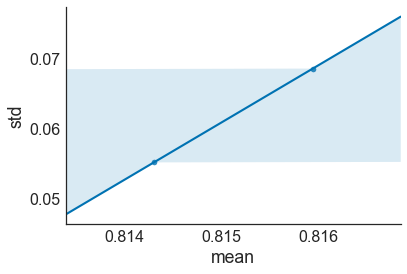

In [93]:
sns.regplot(data=grouped_res['F1-Score'], x='mean', y='std')
sns.despine()

In [94]:
import scipy

scipy.stats.pearsonr(grouped_res['F1-Score']['mean'].values, grouped_res['F1-Score']['std'].values)

/home/mteruel/anaconda2/envs/env35/lib/python3.5/site-packages/scipy/stats/stats.py:3031: RuntimeWarning: invalid value encountered in double_scalars
  prob = _betai(0.5*df, 0.5, df/(df+t_squared))


(0.99999999999999989, nan)

### Comparison between classifiers

In [95]:
METRIC_COLS = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

cc_results_stacked_metrics = cc_results.set_index(
    ['Classifier', 'Dataset', 'Partition']).stack().reset_index().rename(
    columns={0: 'Metric Value', 'level_3': 'Metric'})

/home/mteruel/anaconda2/envs/env35/lib/python3.5/site-packages/seaborn/categorical.py:490: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])


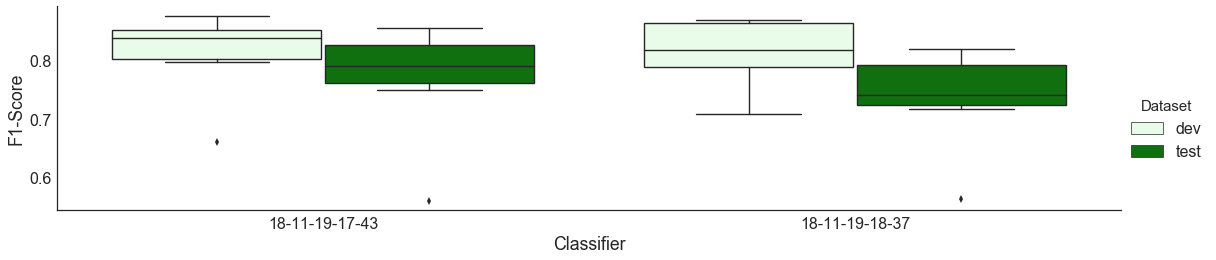

In [96]:
sns.factorplot(data=cc_results,
               x='Classifier', kind='box', y='F1-Score', aspect=4, size=4, color='green', hue='Dataset')

/home/mteruel/anaconda2/envs/env35/lib/python3.5/site-packages/seaborn/categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


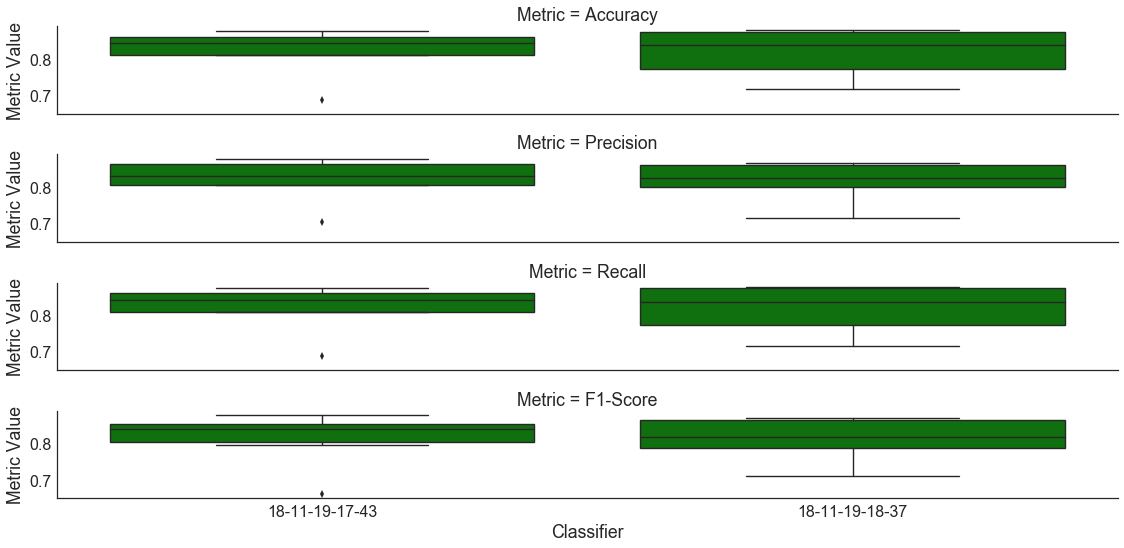

In [97]:
sns.factorplot(data=cc_results_stacked_metrics[cc_results_stacked_metrics.Dataset == 'dev'],
               x='Classifier', kind='box', y='Metric Value', row='Metric', aspect=8, size=2, color='green')

/home/mteruel/anaconda2/envs/env35/lib/python3.5/site-packages/seaborn/categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


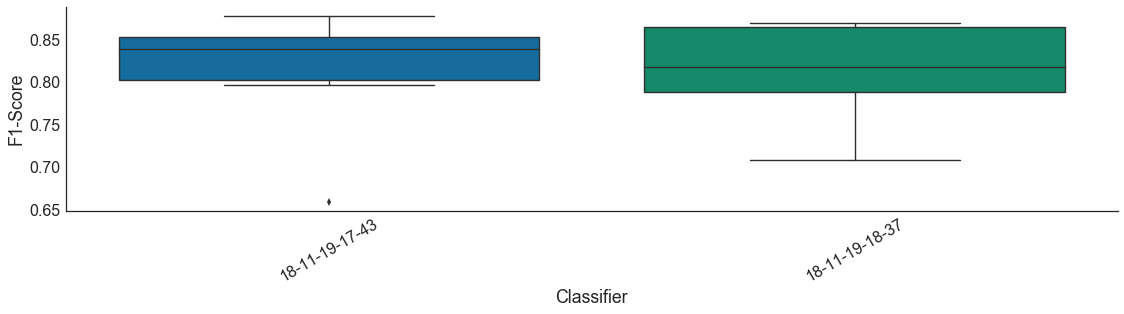

In [98]:
g = sns.factorplot(data=cc_results[(cc_results.Dataset == 'dev')],
                   x='Classifier', y='F1-Score', aspect=4, kind='box')
g.set_xticklabels(rotation=30)

## Learning rate

In [18]:
def learning_single_file(filename):
    result = pandas.read_csv(
        filename, sep='\t', header=None,
        names=['epoch', 'model_name', 'dev_score', 'test_score', 'max_dev_score', 'max_test_score'])
    return result

In [19]:
def learning_filenames(dirname):
    return [learning_metrics for learning_metrics in os.listdir(dirname)
            if os.path.isfile(os.path.join(dirname, learning_metrics)) and 'results' in learning_metrics]

In [20]:
def learning_metrics_single_classifier(classifier_dirpath):
    """Reads all partitions for a single classifier."""
    result = []
    for index, results_file in enumerate(learning_filenames(classifier_dirpath)):
        learning_metrics = learning_single_file(os.path.join(classifier_dirpath, results_file)).drop(
            columns=['model_name', 'max_dev_score', 'max_test_score'])
        learning_metrics = learning_metrics.set_index(['epoch']).stack().reset_index().rename(
            columns={0: 'Metric Value', 'level_1': 'Dataset'})
        learning_metrics['Partition'] = re.search('.*partition(\d+).*', results_file).group(1)
        learning_metrics['Classifier'] = os.path.basename(os.path.normpath(classifier_dirpath))
        result.append(learning_metrics)
    return pandas.concat(result)

In [21]:
def learning_metrics(experiment_dirs):
    """Reads learning metrics for all classifiers"""
    classifier_learning_metrics = []
    for classifier_path in experiment_dirs:
        classifier_learning_metrics.append(learning_metrics_single_classifier(classifier_path))
    return pandas.concat(classifier_learning_metrics)

In [22]:
cc_learning = learning_metrics(CC_EXPERIMENTS_DIRS)
cc_learning[:3]

,epoch,Dataset,Metric Value,Partition,Classifier
0,1,dev_score,0.292841,1,18-11-14-14-49
1,1,test_score,0.315431,1,18-11-14-14-49
2,2,dev_score,0.301625,1,18-11-14-14-49


In [47]:
hyperparameters = pandas.read_csv('../../results/ukpnets/echr_classifiers.tsv', sep='\t',
                                  usecols=['Name', 'Time/Feature', 'Activation', 'Attention'])
hyperparameters = hyperparameters.rename(columns={'Time/Feature': 'Attention type', 'Name': 'Classifier'})
hyperparameters = hyperparameters.replace(
    to_replace=['Word', 'Context'], value=['Word attention', 'Context attention'])
hyperparameters['Attention type'] = hyperparameters['Attention type'].replace('None', 'No attention')
hyperparameters['Activation'] = hyperparameters['Activation'].replace('None', 'Linear')
hyperparameters[:3]

,Classifier,Attention type,Activation,Attention
0,18-11-14-14-49,No attention,Linear,No
1,18-11-14-16-39,No attention,Linear,No
2,18-11-14-18-15,No attention,Linear,No


In [51]:
cc_learning = cc_learning.join(hyperparameters.set_index('Classifier'), on='Classifier')

/home/mteruel/anaconda2/envs/env35/lib/python3.5/site-packages/seaborn/categorical.py:1508: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


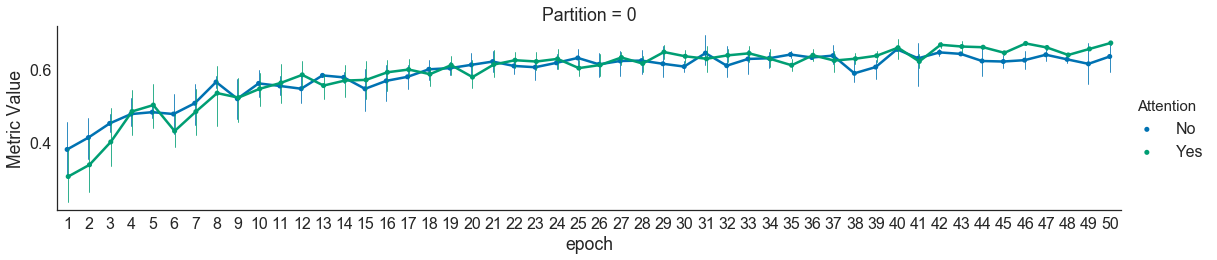

In [73]:
sns.factorplot(data=cc_learning[
                    (cc_learning.Partition.isin(['0'])) & (cc_learning.Dataset == 'dev_score')],
               hue='Attention', x='epoch', y='Metric Value', row='Partition', sharex=True, aspect=4,
               errwidth=0.8, markers='.', dodge=True)

### Confusion matrix

In [24]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Args:
        confusion_matrix: numpy.ndarray
            The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
            Similarly constructed ndarrays can also be used.
        class_names: list
            An ordered list of class names, in the order they index the given confusion matrix.
        figsize: tuple
            A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
            the second determining the vertical size. Defaults to (10,7).
        fontsize: int
            Font size for axes labels. Defaults to 14.
        
    Returns:
        The resulting confusion matrix figure
    """
    df_cm = pandas.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

In [25]:
def plot_confusion_matrix(classifier_name, partition=0):
    for classifier_dirname in CC_EXPERIMENTS_DIRS:
        if not classifier_name in classifier_dirname:
            continue
        prediction_files = prediction_filenames(classifier_dirname)
        prediction_file = None
        for possible_prediction_file in prediction_files:
            if 'partition' + str(partition) in possible_prediction_file and 'dev' in possible_prediction_file:
                prediction_file = possible_prediction_file
                break
        if prediction_file is None:
            raise ValueError('No prediction for the given partition {}'.format(partition))
        predictions = labels_single_file(os.path.join(classifier_dirname, prediction_file))
        labels = numpy.unique(numpy.concatenate([predictions['True'].values, predictions.Predicted.values]))
        print(metrics.classification_report(predictions['True'], predictions.Predicted, labels=labels))
        cm = metrics.confusion_matrix(predictions['True'], predictions.Predicted, labels=labels)
        print(cm.sum())
        print_confusion_matrix(cm, labels)
        return None
    raise ValueError('Classifier not found')

/home/mteruel/anaconda2/envs/env35/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

    B-claim       0.81      0.20      0.33        83
  B-premise       0.00      0.00      0.00        75
    I-claim       0.70      0.57      0.63      2461
  I-premise       0.50      0.45      0.48      1903
          O       0.48      0.73      0.58      1470

avg / total       0.58      0.56      0.56      5992

5992


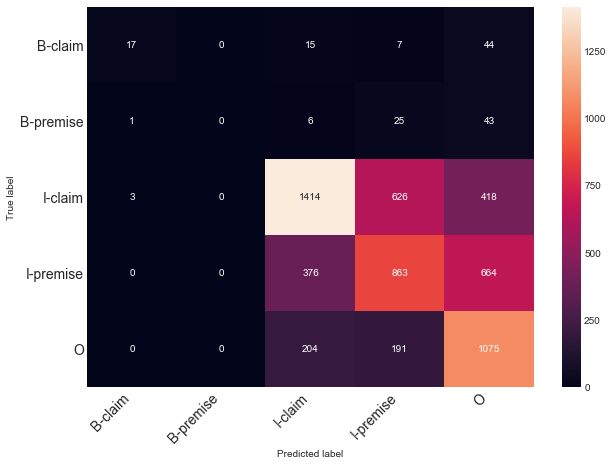

In [27]:
plot_confusion_matrix('18-11-15-04-16', partition=6)

In [ ]:
plot_confusion_matrix('18-06-01-06-57', partition=5)